# LPS and LCS in Human Chromosome 22

In [75]:
using Plots
using DataFrames
using DelimitedFiles
using StringAlgorithms
using LaTeXStrings
include("source/utils.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
include("source/expectation.jl")
include("source/chromosome.jl")
include("source/io.jl")

writegtf (generic function with 1 method)

### The Human Genome
Retrieve the sequences of the human chromosome from the UCSC Genome Browser's data:

- <a href="https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/p14/hg38.p14.fa.gz">HG38.p14</a> 

Unzip with `gzip -d hg38.p14.fa.gz` and move `hg38.p14.fa` to `/data`.

### HG38 Annotations
Retrieve the NCBI annotation for HG38:

- <a href="https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.ncbiRefSeq.gtf.gz">HG38 NCBI RefSeq GTF</a>

Unzip with `gzip -d hg38.ncbiRefSeq.gtf.gz` and move `hg38.ncbiRefSeq.gtf` to `/data`.

### GffRead
The command-line tool GffRead can be downloaded and built from its github repository
- https://github.com/gpertea/gffread,

or installed using a package manager, e.g., `sudo apt install gffread`.

Convert the annotation `.gtf` to a `.gff`, and use the `.gff` to extract reference sequences from the human genome.
```
gffread -E data/hg38.ncbiRefSeq.gtf -o data/hg38.ncbiRefSeq.gff
gffread -w data/hg38.refseqs.fa -g data/hg38.p14.fa data/hg38.ncbiRefSeq.gff
```

In [74]:
anno = readtable("data/hg38.ncbiRefSeq.gtf")
seqs = readfasta("data/hg38.refseqs.fa")
# locate all the transcripts (~ genes) in the annotation
transcript_mask = anno[:, 3] .== "transcript"
# (check that the number of sequences is equal to the number of transcripts)
@assert sum(transcript_mask) == length(seqs)
# locate transcripts for chromosome 22
transcripts = anno[transcript_mask, :]
chr22_mask = transcripts[:, 1] .== "chr22"
# isolate sequences for chromosome 22
chr22_seqs = [seqs[i] for i=1:length(seqs) if chr22_mask[i]]
writefasta("data/chr22.refseqs.fa", chr22_seqs)

### Introns and Intergenic regions

In [89]:
chr22 = sequence(chromosome(22, readgenome("data/hg38.p14.fa"))[1]);
chr22_anno = anno[anno[:, 1] .== "chr22", :]

In [102]:
chr22_intron_anno = chr22_anno[chr22_anno[:, 3] .== "3UTR" .|| chr22_anno[:, 3] .== "5UTR", :]
chr22_intron_intervals = chr22_intron_anno[:, 4:5]
chr22_introns = [chr22[start:stop] for (start,stop)=eachrow(chr22_intron_intervals)]

4935228

In [ ]:
# sample the introns for subsequences with the same length distribution as `chr22_seqs`
chr22_intron_samples =
writesequences("data/chr22.intron-samples.fa", chr22_intron_samples)

In [ ]:
chr22_transcripts_anno = chr22_anno[chr22_anno[:, 3] .== "transcript"]
chr22_transcript_intervals = chr22_transcripts_anno[:, 4:5]

In [ ]:
# sample the negative space for subsequences with the same length distribution as `chr22_seqs`
chr22_intergenic_samples =
writesequences("data/chr22.intergenic-samples.fa", chr22_intergenic_samples)

### Sequence Variants
As before, use EASEL to generate shuffled and reversed variants of chromosomal sequences.

### Compute LPS and LCS

In [ ]:
function llcs(x, y, progressmeter)
    next!(progressmeter)
    length(longestcommonsubstring(x, y)[1])
end
function llps(x, progressmeter)
    next!(progressmeter)
    length(longestpalindromicsubstring(x))
end
function generate_lps(x, resultpath)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llps(x[i], p)
    end
    lx = length.(x)
    print("writing LPS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, results], ["length", "lps"]))
end
function generate_lcs(x, y, resultpath)
    @assert length(x) == length(y)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llcs(x[i], y[i], p)
    end
    lx = length.(x)
    ly = length.(y)
    print("writing LCS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, ly, results], ["length1", "length2", "lcs"]))
end

207289-element Vector{FASTX.FASTA.Record}:
 FASTX.FASTA.Record:
  description: "rna-TRNF"
     sequence: "GTTTATGTAGCTTACCTCCTCAAAGCAATACACTGAAAA…"
 FASTX.FASTA.Record:
  description: "rna-RNR1"
     sequence: "AATAGGTTTGGTCCTAGCCTTTCTATTAGCTCTTAGTAA…"
 FASTX.FASTA.Record:
  description: "rna-TRNV"
     sequence: "CAGAGTGTAGCTTAACACAAAGCACCCAACTTACACTTA…"
 FASTX.FASTA.Record:
  description: "rna-RNR2"
     sequence: "GCTAAACCTAGCCCCAAACCCACTCCACCTTACTACCAG…"
 FASTX.FASTA.Record:
  description: "rna-TRNL1"
     sequence: "gttaagatggcagagcccggtaatcgcataaaacttaaa…"
 FASTX.FASTA.Record:
  description: "rna-ND1 CDS=1-956"
     sequence: "aTACCCATGGCCAACCTCCTACTCCTCATTGTACCCATT…"
 FASTX.FASTA.Record:
  description: "rna-TRNI"
     sequence: "AGAAATATGTCTGATAAAAGAGTTACTTTGATAGAGTAA…"
 FASTX.FASTA.Record:
  description: "rna-TRNQ"
     sequence: "taggatggggtgtgataggtggcacggagaattttggat…"
 FASTX.FASTA.Record:
  description: "rna-TRNM"
     sequence: "AGTAAGGTCAGCTAAATAAGCTATCGGGCCCATACCCCG…"
 F

## Plot [python]

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
from math import *
cluster = lambda data, parameter, lo, hi : [data[parameter==x] for x in range(lo,hi+1)]
robust_cluster_means = lambda data_clusters : [stats.mean(cluster) if len(cluster)>0 else -1 for cluster in data_clusters]
def scatter_cluster_means(axis, frame, datakey, parakey, lo, hi, color, marker, label):
    clusters = cluster(frame[datakey], frame[parakey], lo, hi)
    x = robust_cluster_means(clusters)
    y = list(range(lo,hi+1))
    axis.scatter(y, x, 1, 
                 color=color, label=label, marker=marker, alpha=0.2)
exp_lcs = lambda n, lambda2: 2*log(n, 1/lambda2)
exp_lps = lambda n, lambda2: exp_lcs(n, lambda2) + 1
def plot_expected_lcs(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lcs(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LCS]")
def plot_expected_lps(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lps(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LPS]")
def setup_axis1(axis,xlo=1,xhi=1e6,ylo=0,yhi=40):
    axis.set_xlim(xlo,xhi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length")
    axis.set_ylim(ylo,yhi)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length")
    leg = axis.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
def setup_axis2(axis,xlo=1,xhi=1e6,ylo=0,yhi=40):
    axis.set_xlim(xlo,xhi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length")
    axis.set_ylim(ylo,yhi)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length")
    leg = axis.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

In [15]:
resultpaths = [
    "outputs/lcs_proteincoding_shuf.txt", 
    "outputs/lcs_rnacoding_shuf.txt", 
    "outputs/lcs_pseudogene_shuf.txt", 
    "outputs/lps_proteincoding.txt", 
    "outputs/lps_rnacoding.txt", 
    "outputs/lps_pseudogene.txt", 
    "outputs/lps_shuf_proteincoding.txt", 
    "outputs/lps_shuf_rnacoding.txt", 
    "outputs/lps_shuf_pseudogene.txt", 
    "outputs/lps_hardmasked_proteincoding.txt",
    "outputs/lps_hardmasked_rnacoding.txt",
    "outputs/lps_hardmasked_pseudogene.txt"]

(lcs_protein_shuf, lcs_rna_shuf, lcs_pseudogene_shuf, 
 lps_protein, lps_rna, lps_pseudogene, 
 lps_shuf_protein, lps_shuf_rna, lps_shuf_pseudogene, 
 lps_masked_protein, lps_masked_rna, lps_masked_pseudogene) = [pd.read_csv(x) for x in resultpaths]

# coincidence frequency for our annotation of chr22
lambda2 = 0.25080397536793314

lcsmaroon = "#8a1414"
sprotblue = "#0000ff"
shufred = "#ff8800"
maskgreen = "#0cff0c"

lo = lo_protein = lo_rna = lo_pseudogene = 1
hi = hi_protein = hi_rna = hi_pseudogene = int(1e6)

In [16]:
from time import time

1 3.838539123535156e-05
2 60.643105268478394
3 126.89084982872009
4 194.6873643398285
5 194.9063172340393
6 261.5619487762451
7 330.8176622390747
8 398.9262788295746
9 399.17886543273926
10 487.87491512298584
11 555.8415360450745
12 621.9861187934875


/tmp/ipykernel_12347/2109278256.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


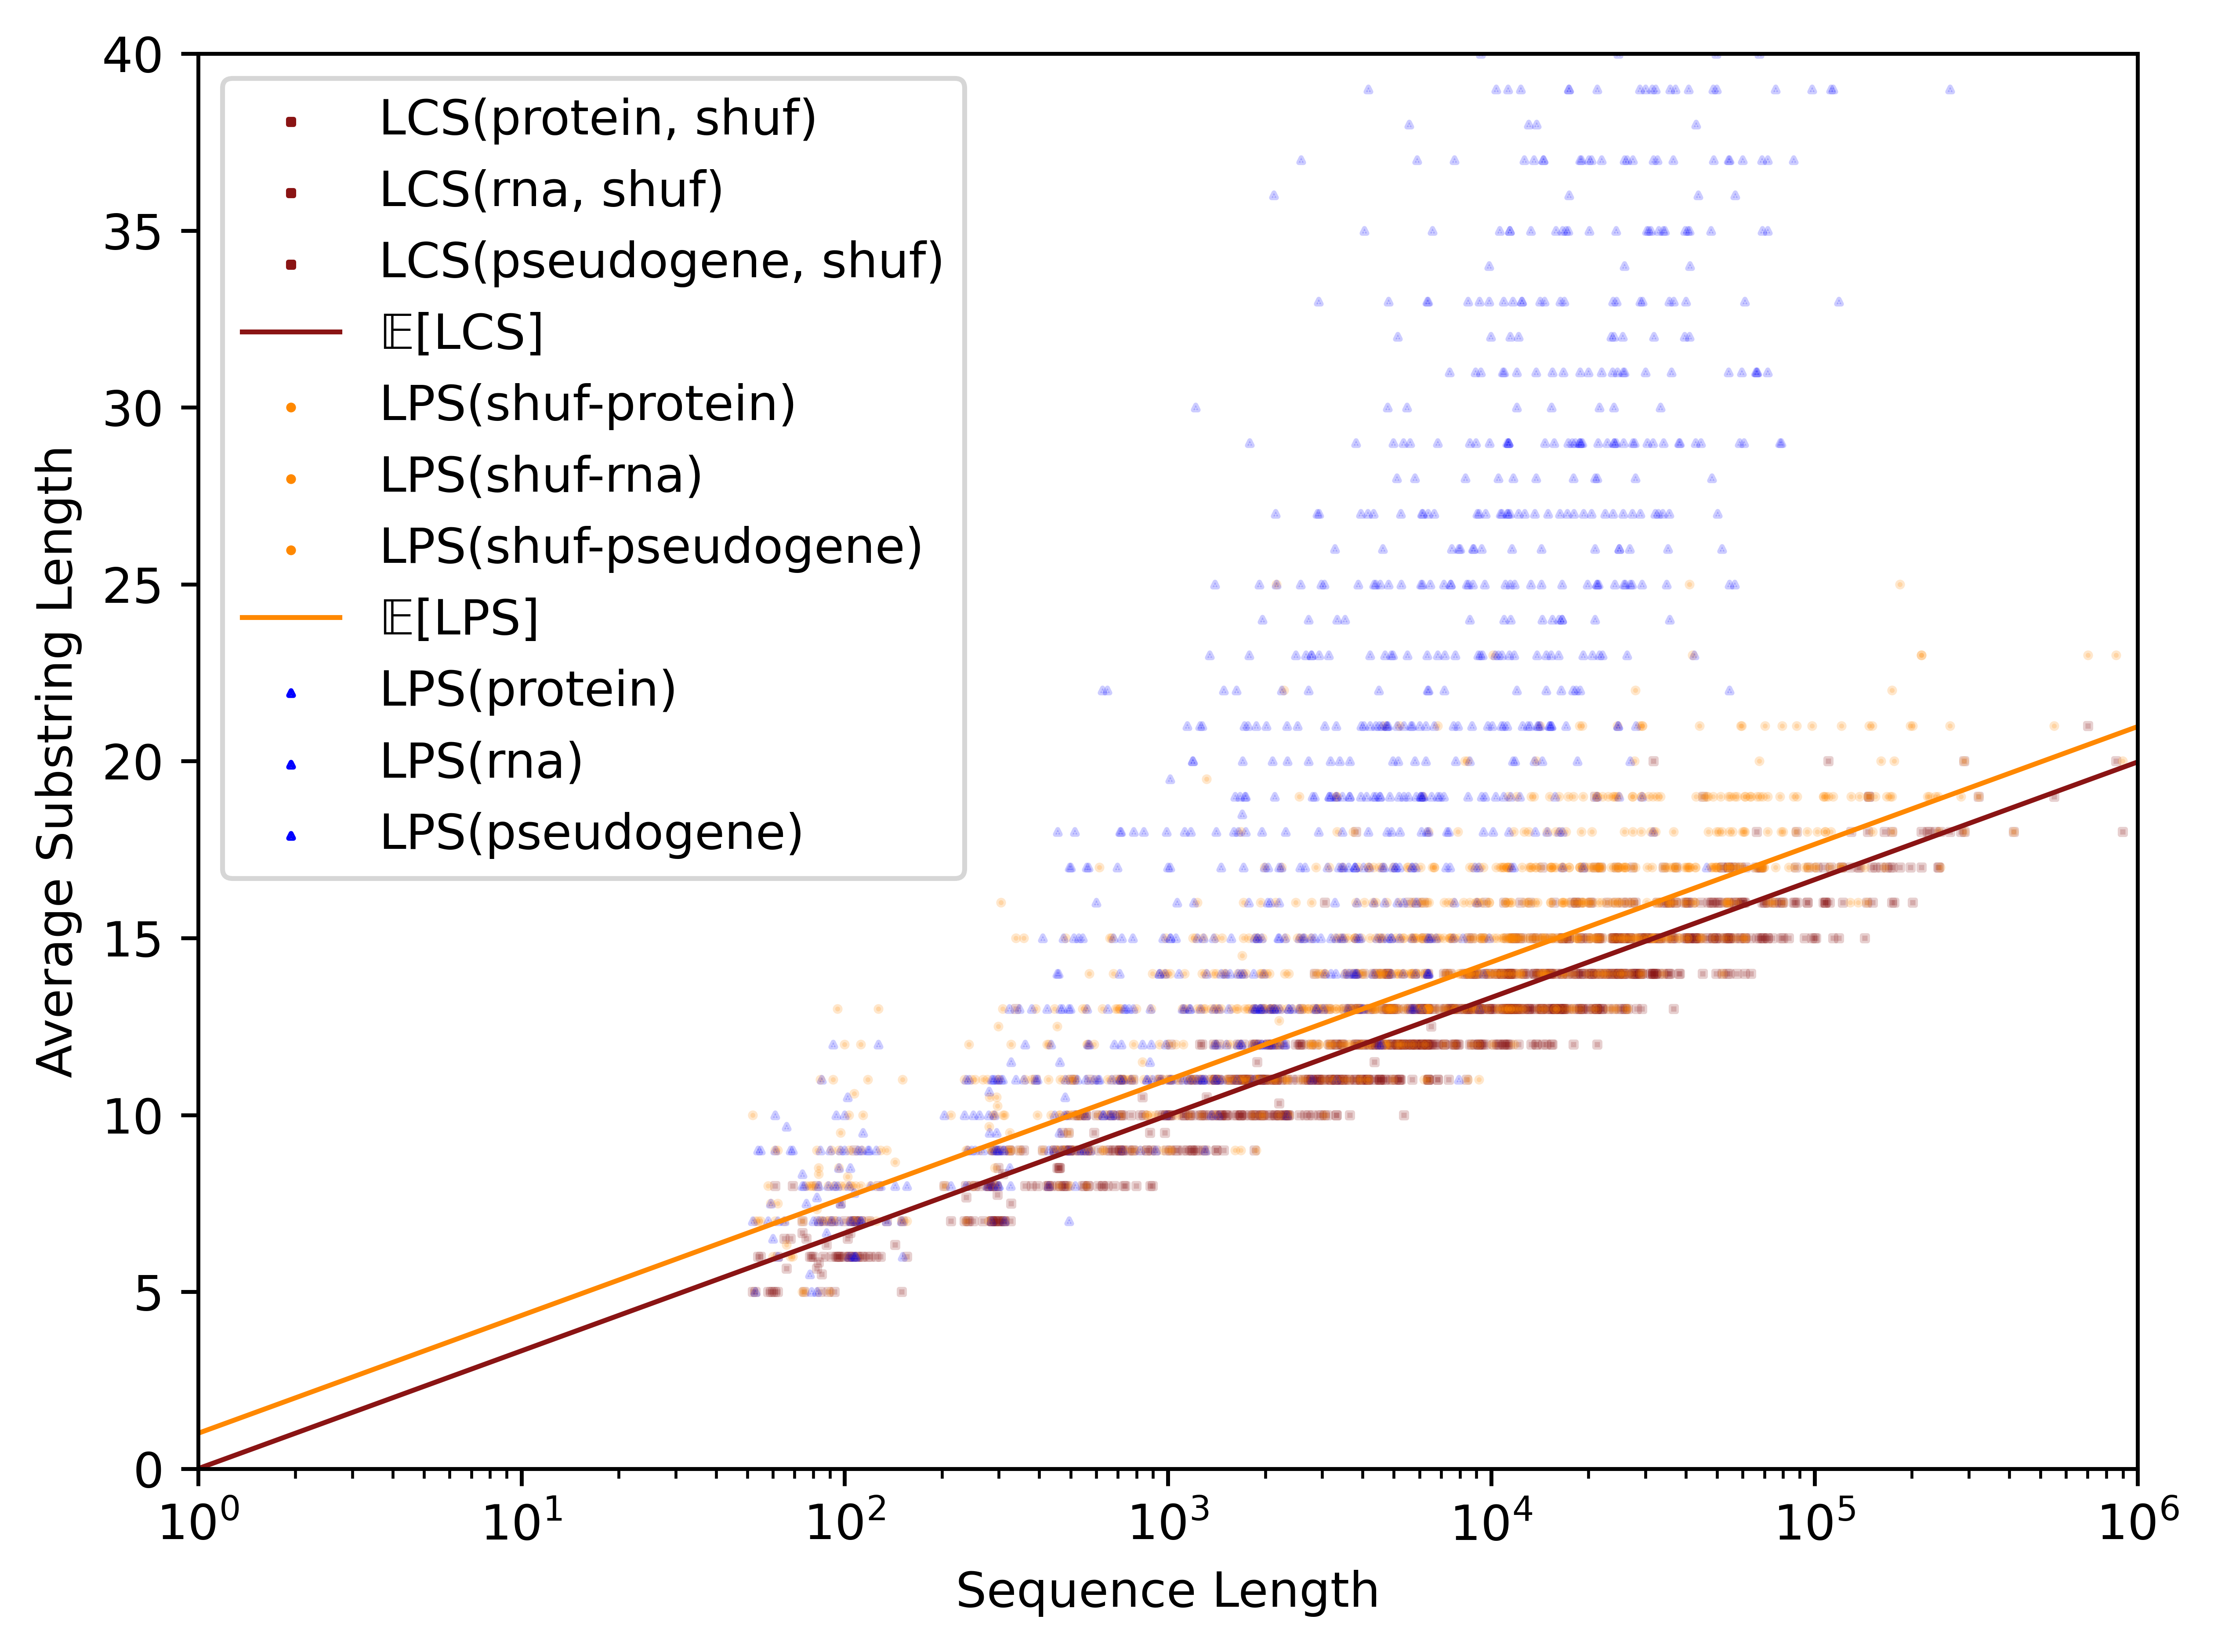

In [17]:
fig, ax = plt.subplots(dpi=800)
start_time = time()
print(1, time() - start_time)
scatter_cluster_means(ax, lcs_protein_shuf, "lcs", "length1", lo_protein, hi_protein,
                      lcsmaroon, 's', "LCS(protein, shuf)")
print(2, time() - start_time)
scatter_cluster_means(ax, lcs_rna_shuf, "lcs", "length1", lo_rna, hi_rna,
                      lcsmaroon, 's', "LCS(rna, shuf)")
print(3, time() - start_time)
scatter_cluster_means(ax, lcs_pseudogene_shuf, "lcs", "length1", lo_pseudogene, hi_pseudogene,
                      lcsmaroon, 's', "LCS(pseudogene, shuf)")
print(4, time() - start_time)
plot_expected_lcs(ax, lambda2, lo, hi, lcsmaroon)
print(5, time() - start_time)
scatter_cluster_means(ax, lps_shuf_protein, "lps", "length", lo_protein, hi_protein,
                      shufred, 'o', "LPS(shuf-protein)")
print(6, time() - start_time)
scatter_cluster_means(ax, lps_shuf_rna, "lps", "length", lo_rna, hi_rna,
                      shufred, 'o', "LPS(shuf-rna)")
print(7, time() - start_time)
scatter_cluster_means(ax, lps_shuf_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred, 'o', "LPS(shuf-pseudogene)")
print(8, time() - start_time)
?????/''
print(9, time() - start_time)
scatter_cluster_means(ax, lps_protein, "lps", "length", lo_protein, hi_protein,
                      sprotblue, '^', "LPS(protein)")
print(10, time() - start_time)
scatter_cluster_means(ax, lps_rna, "lps", "length", lo_rna, hi_rna,
                      sprotblue, '^', "LPS(rna)")
print(11, time() - start_time)
scatter_cluster_means(ax, lps_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      sprotblue, '^', "LPS(pseudogene)")
print(12, time() - start_time)
setup_axis1(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_a.png")

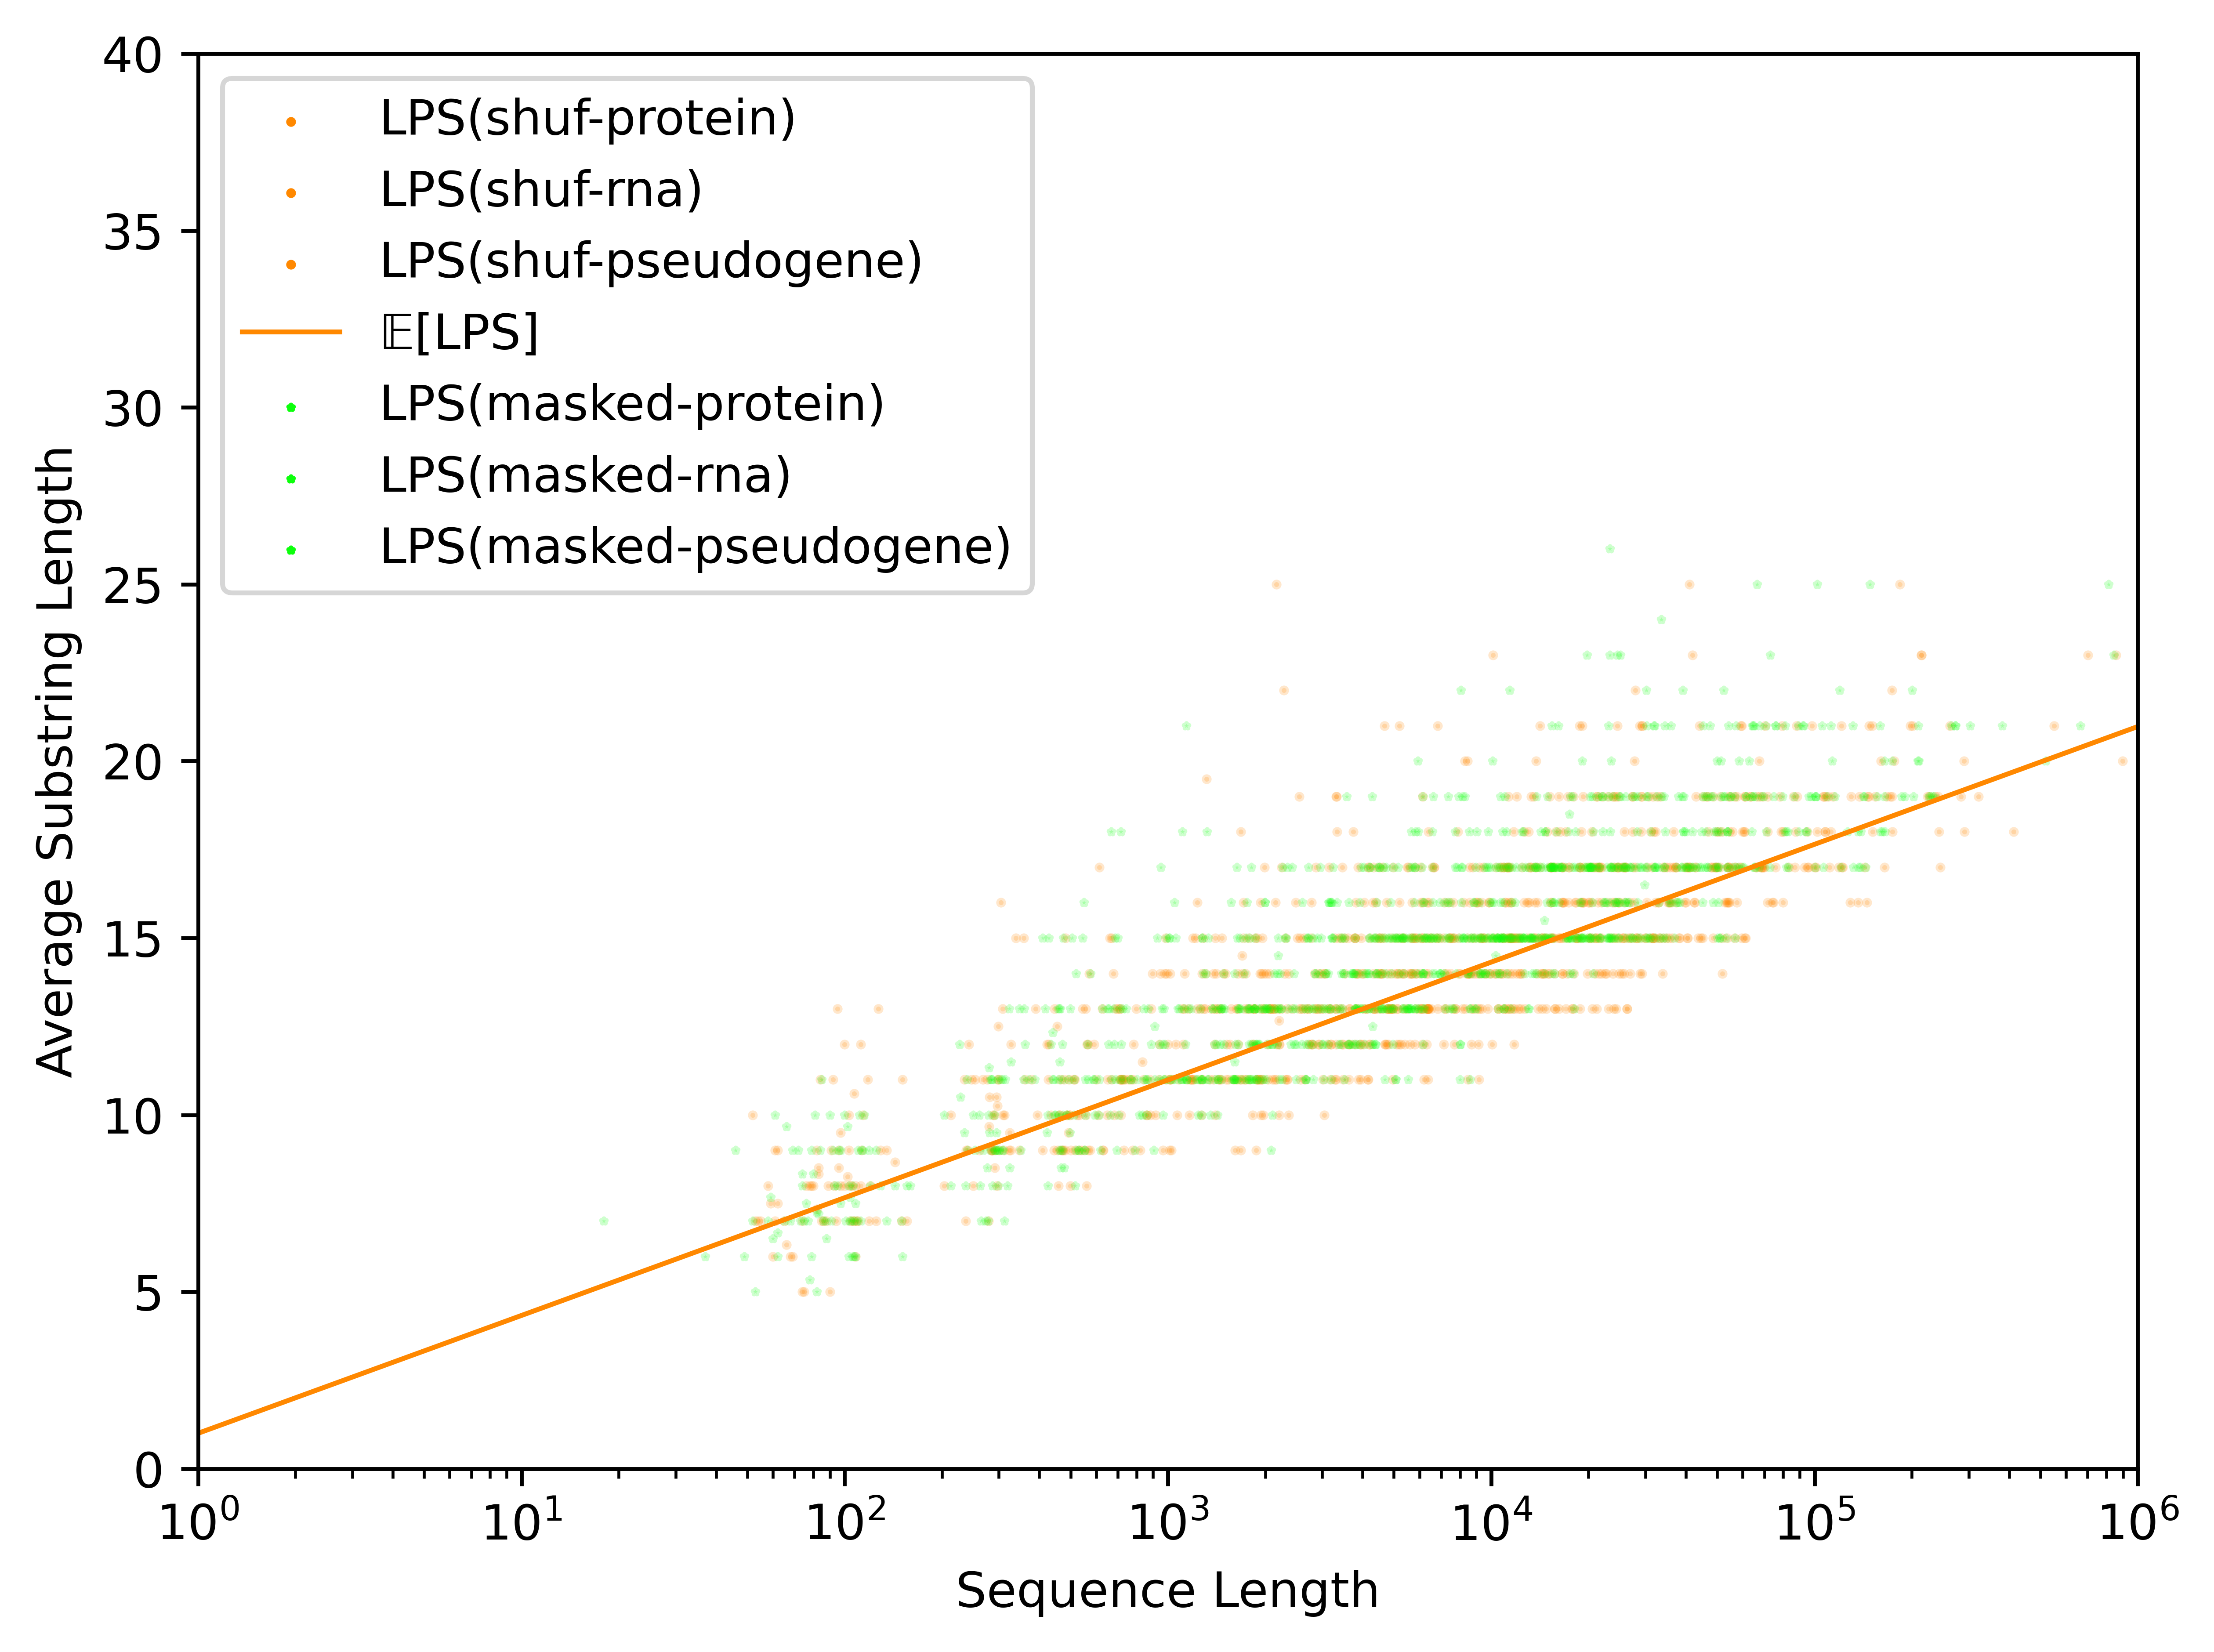

In [18]:
fig,ax = plt.subplots(dpi=800)
scatter_cluster_means(ax, lps_shuf_protein, "lps", "length", lo_protein, hi_protein,
                      shufred, 'o', "LPS(shuf-protein)")
scatter_cluster_means(ax, lps_shuf_rna, "lps", "length", lo_rna, hi_rna,
                      shufred, 'o', "LPS(shuf-rna)")
scatter_cluster_means(ax, lps_shuf_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred, 'o', "LPS(shuf-pseudogene)")
plot_expected_lps(ax, lambda2, lo, hi, shufred)

scatter_cluster_means(ax, lps_masked_protein, "lps", "length", lo_protein, hi_protein,
                      maskgreen, '*', "LPS(masked-protein)")
scatter_cluster_means(ax, lps_masked_rna, "lps", "length", lo_rna, hi_rna,
                      maskgreen, '*', "LPS(masked-rna)")
scatter_cluster_means(ax, lps_masked_pseudogene, "lps", "length", lo_pseudogene, hi_pseudogene,
                      maskgreen, '*', "LPS(masked-pseudogene)")
setup_axis2(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_b.png")